# Figure 1: Lightning Climatology Map

In [3]:
import xarray as xr
import xesmf as xe
import numpy as np
import dask
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

In [2]:
# Load in countries shapefile for country borders
PATH_TO_SHAPEFILE = 'data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

ERROR 1: PROJ: proj_create_from_database: Open of /home/disk/p/rjones98/anaconda3/envs/plotenv/share/proj failed


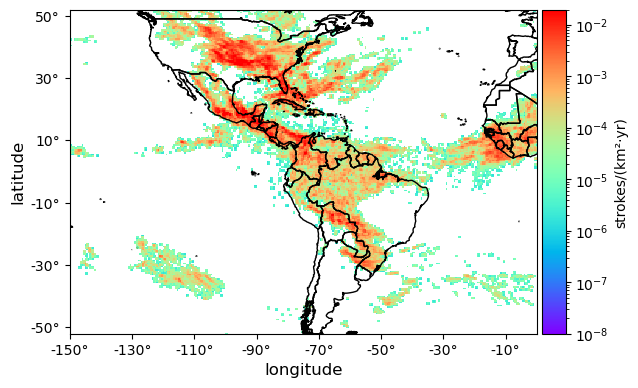

In [3]:
# Import lightning dataset (this data is not publicly available, please go to https://wwlln.net to request lightning data
ds = xr.open_dataset('data/input_data/input_sample.nc')

fig, ax = plt.subplots(figsize=(6.4, 4.8))
base = countries.plot(ax=ax, color=(1, 1, 1, 0.0), edgecolor='black', zorder=2)

im = ds.ltg.mean(dim='time').plot(ax=ax, cmap='rainbow', zorder=1,                 # Replace lightning variable with the name of your variable
                                  norm=colors.LogNorm(vmin=1E-8, vmax=2E-2), 
                                  add_colorbar=False)  # Remove default colorbar

# Set up an axis for the colorbar with the same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust width with size

cbar = fig.colorbar(im, cax=cax)
cbar.set_label('strokes/(km²·yr)')

# Format tick labels with degree symbols
def format_degrees(x, pos):
    return f"{int(x)}°"

ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)

# Set exact plot limits
ax.set_xlim(-150, 0)
ax.set_ylim(-52, 52)

# Apply formatted ticks
ax.set_xticks(range(-150, 1, 20))
ax.set_yticks(range(-50, 51, 20))

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))

plt.show()

# Figure 2: Resolution and Kernel Size FSS (need to do)

## Spatial and Temporal Resolution

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.stats import linregress
from shapely.geometry import Point
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import uniform_filter

In [3]:
ds1 = xr.open_dataset('data/input_data/full_12_input_sample.nc')     #Full-Degree, 12-Hourly
ds2 = xr.open_dataset('data/input_data/full_3_input_sample.nc')   #Full-Degree, 3-Hourly
ds3 = xr.open_dataset('data/input_data/half_12_input_sample.nc')  #Half-Degree, 12-Hourly

cplrstw1 = xr.open_dataset('data/input_data/full_12_cplrstw_sample.nc')          #Full-Degree, 12-Hourly
cplrstw2 = xr.open_dataset('data/input_data/full_3_cplrstw_sample.nc')       #Full-Degree, 3-Hourly
cplrstw3 = xr.open_dataset('data/input_data/half_12_cplrstw_sample.nc')   #Half-Degree, 12-Hourly

In [4]:
tmp11 = ds1.ltg
tmp12 = cplrstw1.ltg
tmp21 = ds2.ltg
tmp22 = cplrstw2.ltg
tmp31 = ds3.ltg.isel(lat=slice(0, 104))
tmp32 = cplrstw3.ltg

In [5]:
tmp11 = tmp11.fillna(0)
tmp21 = tmp21.fillna(0)
tmp31 = tmp31.fillna(0)

In [6]:
def compute_fss(obs, pred, threshold, window_size):
    """
    Compute the Fractions Skill Score (FSS) for a given observation and prediction field.

    Parameters:
    - obs (np.array): 2D binary observation field (1 for event, 0 for no event)
    - pred (np.array): 2D binary prediction field (1 for event, 0 for no event)
    - threshold (float): Threshold to binarize the fields
    - window_size (int): Size of the neighborhood window

    Returns:
    - fss (float): Fractions Skill Score
    """
    # Convert fields to binary based on threshold
    obs_bin = (obs >= threshold).astype(int)
    pred_bin = (pred >= threshold).astype(int)

    # Compute fractional coverage using a moving window
    obs_frac = uniform_filter(obs_bin.astype(float), size=window_size, mode='constant', cval=0)
    pred_frac = uniform_filter(pred_bin.astype(float), size=window_size, mode='constant', cval=0)

    # Compute numerator and denominator of FSS formula
    numerator = np.sum((pred_frac - obs_frac) ** 2)
    denominator = np.sum(pred_frac**2 + obs_frac**2)

    # Compute FSS
    fss = 1 - (numerator / denominator)
    return fss

# Define parameters
threshold = 1E-5  # Define a lightning threshold for event occurrence
window_size = 3  # Example window size (5x5 grid points)

# Extract time range
time_range12 = ds1.time
time_range3 = ds2.time

# Store FSS results for each time step
fss_scores_full12 = []
fss_scores_full3 = []
fss_scores_half12 = []

for i in range(len(time_range12)):
    obs_values_full12 = tmp11.sel(time=time_range12[i]).values
    obs_values_half12 = tmp31.sel(time=time_range12[i]).values
    pred_values_full12 = tmp12.sel(time=time_range12[i]).values
    pred_values_half12 = tmp32.sel(time=time_range12[i]).values
    
    # Compute FSS
    fss_full12 = compute_fss(obs_values_full12, pred_values_full12, threshold, window_size)
    fss_half12 = compute_fss(obs_values_half12, pred_values_half12, threshold, window_size)
    
    fss_scores_full12.append(fss_full12)
    fss_scores_half12.append(fss_half12)

for j in range(len(time_range3)):
    obs_values_full3 = tmp21.sel(time=time_range3[j]).values
    pred_values_full3 = tmp22.sel(time=time_range3[j]).values
    
    fss_full3 = compute_fss(obs_values_full3, pred_values_full3, threshold, window_size)
    fss_scores_full3.append(fss_full3)

# Convert to xarray DataArray for easy analysis
fss_da_full12 = xr.DataArray(fss_scores_full12, coords={"time": time_range12}, dims="time")
fss_da_full3 = xr.DataArray(fss_scores_full3, coords={"time": time_range3}, dims="time")
fss_da_half12 = xr.DataArray(fss_scores_half12, coords={"time": time_range12}, dims="time")

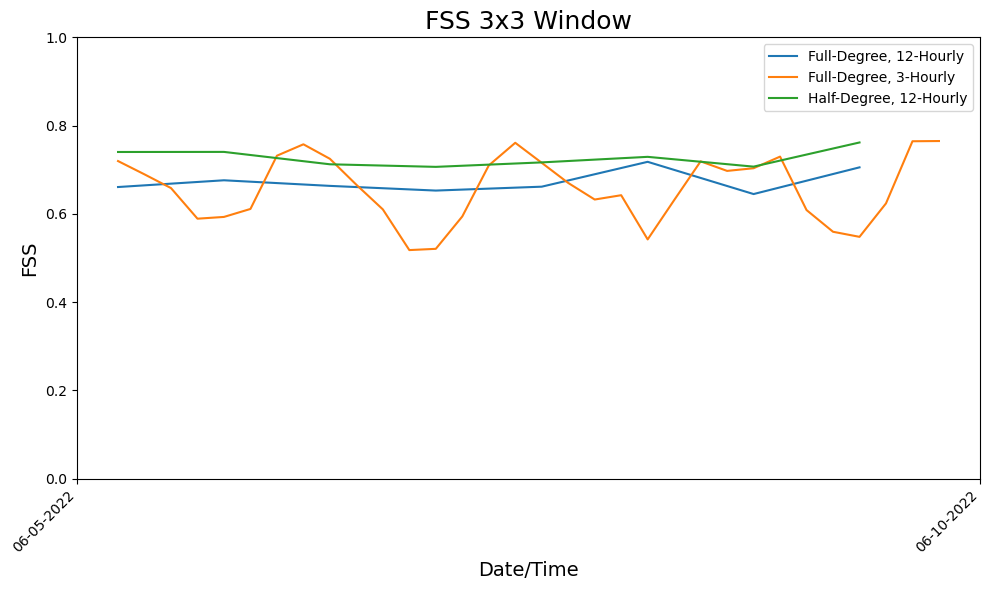

In [7]:
myFmt = DateFormatter("%m-%d-%Y")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fss_da_full12.time, fss_da_full12, label='Full-Degree, 12-Hourly')
ax.plot(fss_da_full3.time, fss_da_full3, label='Full-Degree, 3-Hourly')
ax.plot(fss_da_half12.time, fss_da_half12, label='Half-Degree, 12-Hourly')
ax.set_title('FSS 3x3 Window', fontsize=18)
ax.set_xlabel('Date/Time', fontsize=14)
ax.set_ylabel('FSS', fontsize=14)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_locator(MonthLocator(interval=3, bymonthday=1))
ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Kernel Size

In [8]:
ds = xr.open_dataset('data/input_data/full_3_input_sample.nc')
cplrstw1 = xr.open_dataset('data/input_data/one_cplrstw_sample.nc')
cplrstw3 = xr.open_dataset('data/input_data/three_cplrstw_sample.nc')
cplrstw5 = xr.open_dataset('data/input_data/five_cplrstw_sample.nc')

In [9]:
tmp1 = ds.ltg
tmp2 = cplrstw1.ltg
tmp3 = cplrstw3.ltg
tmp4 = cplrstw5.ltg

In [10]:
tmp1 = tmp1.fillna(0)

In [11]:
def compute_fss(obs, pred, threshold, window_size):
    """
    Compute the Fractions Skill Score (FSS) for a given observation and prediction field.

    Parameters:
    - obs (np.array): 2D binary observation field (1 for event, 0 for no event)
    - pred (np.array): 2D binary prediction field (1 for event, 0 for no event)
    - threshold (float): Threshold to binarize the fields
    - window_size (int): Size of the neighborhood window

    Returns:
    - fss (float): Fractions Skill Score
    """
    # Convert fields to binary based on threshold
    obs_bin = (obs >= threshold).astype(int)
    pred_bin = (pred >= threshold).astype(int)

    # Compute fractional coverage using a moving window
    obs_frac = uniform_filter(obs_bin.astype(float), size=window_size, mode='constant', cval=0)
    pred_frac = uniform_filter(pred_bin.astype(float), size=window_size, mode='constant', cval=0)

    # Compute numerator and denominator of FSS formula
    numerator = np.sum((pred_frac - obs_frac) ** 2)
    denominator = np.sum(pred_frac**2 + obs_frac**2)

    # Compute FSS
    fss = 1 - (numerator / denominator)
    return fss

# Define parameters
threshold = 1E-5  # Define a lightning threshold for event occurrence
window_size = 3  # Example window size (5x5 grid points)

# Extract time range
time_range = ds.sel(time=slice('2022-01-01', '2023-12-31')).time

# Store FSS results for each time step
fss_scores_1 = []
fss_scores_3 = []
fss_scores_5 = []

for i in range(len(time_range)):
    obs_values = tmp1.sel(time=time_range[i]).values
    pred_values_1 = tmp2.sel(time=time_range[i]).values
    pred_values_3 = tmp3.sel(time=time_range[i]).values
    pred_values_5 = tmp4.sel(time=time_range[i]).values
    
    # Compute FSS
    fss_1 = compute_fss(obs_values, pred_values_1, threshold, window_size)
    fss_3 = compute_fss(obs_values, pred_values_3, threshold, window_size)
    fss_5 = compute_fss(obs_values, pred_values_5, threshold, window_size)
    
    fss_scores_1.append(fss_1)
    fss_scores_3.append(fss_3)
    fss_scores_5.append(fss_5)

# Convert to xarray DataArray for easy analysis
fss_da_1 = xr.DataArray(fss_scores_1, coords={"time": time_range}, dims="time")
fss_da_3 = xr.DataArray(fss_scores_3, coords={"time": time_range}, dims="time")
fss_da_5 = xr.DataArray(fss_scores_5, coords={"time": time_range}, dims="time")

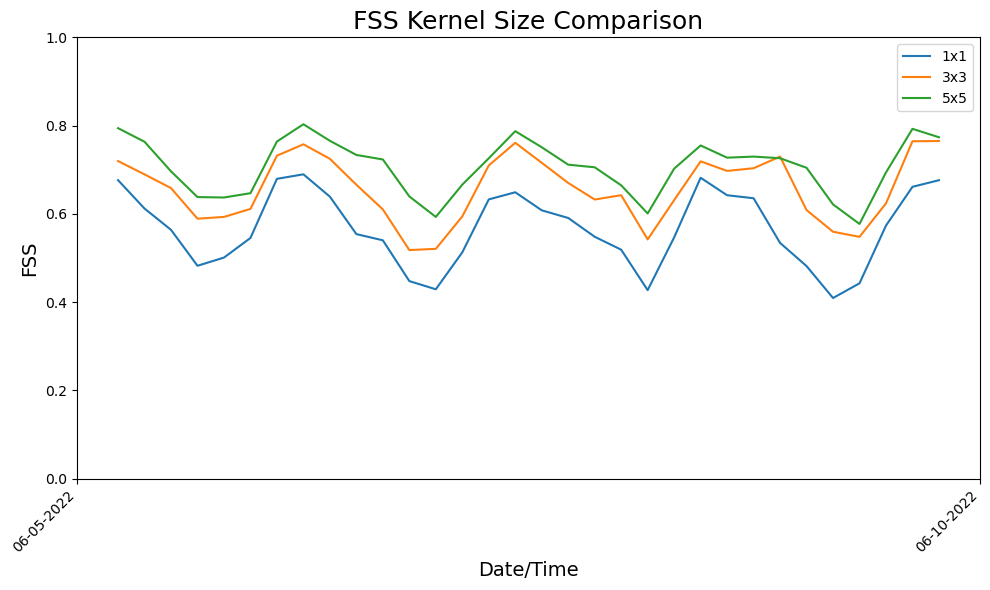

In [12]:
# Plot
myFmt = DateFormatter("%m-%d-%Y")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fss_da_1.time, fss_da_1, label='1x1')
ax.plot(fss_da_3.time, fss_da_3, label='3x3')
ax.plot(fss_da_5.time, fss_da_5, label='5x5')
ax.set_title('FSS Kernel Size Comparison', fontsize=18)
ax.set_xlabel('Date/Time', fontsize=14)
ax.set_ylabel('FSS', fontsize=14)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_locator(MonthLocator(interval=3, bymonthday=1))
ax.xaxis.set_major_formatter(DateFormatter("%m-%d-%Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Combined Figure

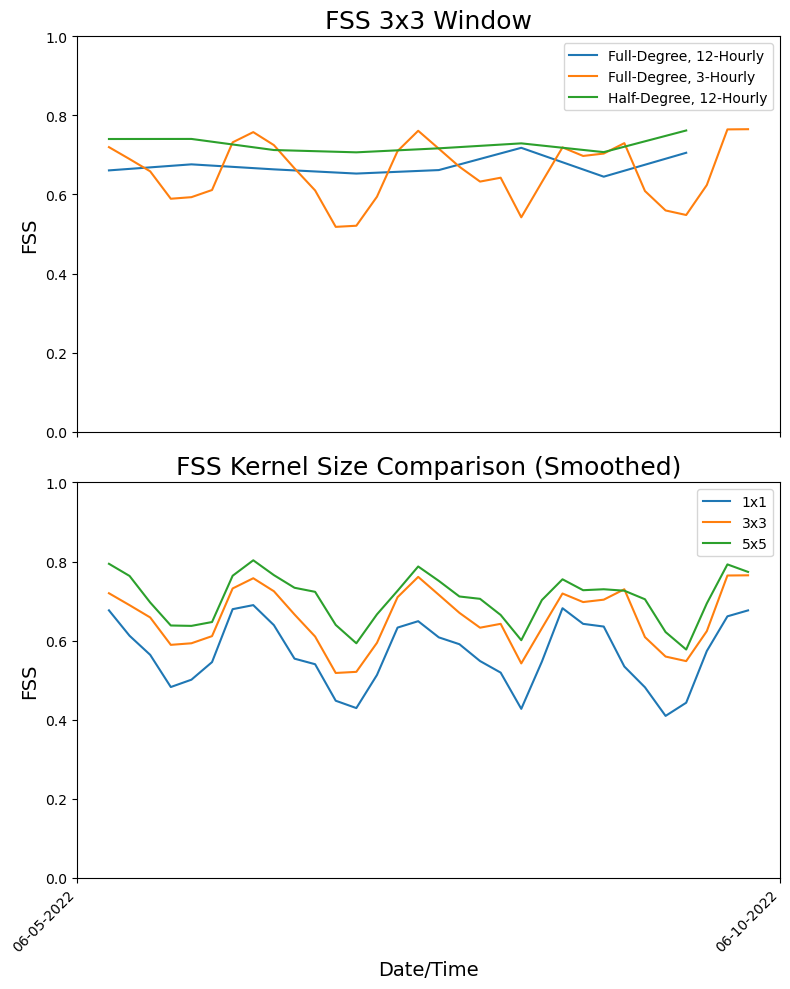

In [13]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10), sharex=True)

# Plot 1
axs[0].plot(fss_da_full12.time, fss_da_full12, label='Full-Degree, 12-Hourly')
axs[0].plot(fss_da_full3.time, fss_da_full3, label='Full-Degree, 3-Hourly')
axs[0].plot(fss_da_half12.time, fss_da_half12, label='Half-Degree, 12-Hourly')
axs[0].set_title('FSS 3x3 Window', fontsize=18)
axs[0].set_ylabel('FSS', fontsize=14)
axs[0].legend()
axs[0].set_ylim([0, 1])

# Plot 2
myFmt = DateFormatter("%m-%d-%Y")
axs[1].plot(fss_da_1.time, fss_da_1, label='1x1')
axs[1].plot(fss_da_3.time, fss_da_3, label='3x3')
axs[1].plot(fss_da_5.time, fss_da_5, label='5x5')
axs[1].set_title('FSS Kernel Size Comparison (Smoothed)', fontsize=18)
axs[1].set_xlabel('Date/Time', fontsize=14)
axs[1].set_ylabel('FSS', fontsize=14)
axs[1].legend()
axs[1].set_ylim([0, 1])
axs[1].xaxis.set_major_locator(MonthLocator(interval=3, bymonthday=1))
axs[1].xaxis.set_major_formatter(DateFormatter("%m-%d-%Y"))
plt.setp(axs[1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Figure 3: WWLLN and Modeled Output Maps

In [10]:
import xarray as xr
import numpy as np
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.stats import linregress
from shapely.geometry import Point
import seaborn as sns

In [19]:
# Load in countries shapefile for country borders
PATH_TO_SHAPEFILE = 'data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

In [44]:
#Load input and output datasets
ds = xr.open_dataset('data/input_data/input_sample.nc')
cp = xr.open_dataset('data/cnn_output/cp_sample.nc')
cplrstw = xr.open_dataset('data/cnn_output/cplrstw_sample_main.nc')

In [45]:
#Calculate slope for R14 parameterization
x = ds.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true = ds.cape_precip.mean(dim='time').stack(point=["lat", "lon"])
y_11 = x

slope, intercept, r_value, p_value, std_err = linregress(x, y_true)

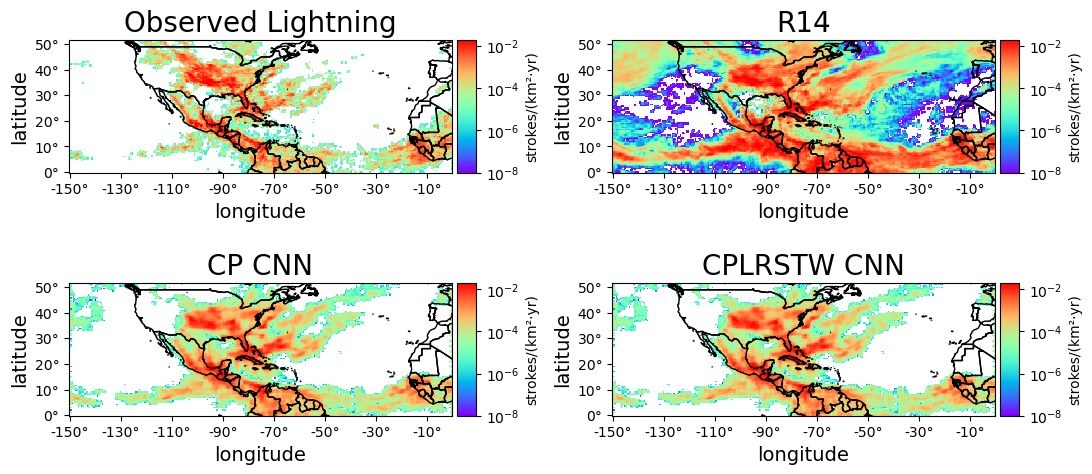

In [46]:
def format_degrees(x, pos):
    return f"{int(x)}°"
    
fig, axs = plt.subplots(2, 2, figsize=(11,5))
    
base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[0, 0])
im0 = ds.ltg.mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),add_colorbar=False)
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust width with size
cbar = fig.colorbar(im0, cax=cax)
cbar.set_label('strokes/(km²·yr)')

axs[0, 0].set_xticks(range(-150, 1, 20))
axs[0, 0].set_yticks(range(0, 51, 10))
axs[0, 0].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[0, 0].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[0, 0].set_title('Observed Lightning', fontsize=20)
axs[0, 0].set_xlabel('longitude', fontsize=14)
axs[0, 0].set_ylabel('latitude', fontsize=14)

base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[0, 1])
im1 = (ds.cape_precip/slope).mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),add_colorbar=False)
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust width with size
cbar = fig.colorbar(im1, cax=cax)
cbar.set_label('strokes/(km²·yr)')

axs[0, 1].set_xticks(range(-150, 1, 20))
axs[0, 1].set_yticks(range(0, 51, 10))
axs[0, 1].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[0, 1].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[0, 1].set_title('R14', fontsize=20)
axs[0, 1].set_xlabel('longitude', fontsize=14)
axs[0, 1].set_ylabel('latitude', fontsize=14)

base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[1, 0])
im2 = cp.ltg.mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),add_colorbar=False)
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust width with size
cbar = fig.colorbar(im2, cax=cax)
cbar.set_label('strokes/(km²·yr)')

axs[1, 0].set_xticks(range(-150, 1, 20))
axs[1, 0].set_yticks(range(0, 51, 10))
axs[1, 0].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[1, 0].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[1, 0].set_title('CP CNN', fontsize=20)
axs[1, 0].set_xlabel('longitude', fontsize=14)
axs[1, 0].set_ylabel('latitude', fontsize=14)

base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[1, 1])
im3 = cplrstw.ltg.mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),add_colorbar=False)
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust width with size
cbar = fig.colorbar(im3, cax=cax)
cbar.set_label('strokes/(km²·yr)')

axs[1, 1].set_xticks(range(-150, 1, 20))
axs[1, 1].set_yticks(range(0, 51, 10))
axs[1, 1].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[1, 1].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[1, 1].set_title('CPLRSTW CNN', fontsize=20)
axs[1, 1].set_xlabel('longitude', fontsize=14)
axs[1, 1].set_ylabel('latitude', fontsize=14)

#plt.suptitle(f"Observed and Deep Learning Model Predicted Lightning Stroke Density", fontsize = 56)
plt.tight_layout(pad=1.0)

# Figure 4: Difference Maps

In [9]:
import xarray as xr
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import linregress
from shapely.geometry import Point
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [32]:
# Load in countries shapefile for country borders
PATH_TO_SHAPEFILE = 'data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

In [33]:
#Load input and output datasets
ds = xr.open_dataset('data/input_data/input_sample.nc')
cp = xr.open_dataset('data/cnn_output/cp_sample.nc')
cplrstw = xr.open_dataset('data/cnn_output/cplrstw_sample_main.nc')

In [34]:
#Calculate slope for R14 parameterization
x = ds.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true = ds.cape_precip.mean(dim='time').stack(point=["lat", "lon"])
y_11 = x

slope, intercept, r_value, p_value, std_err = linregress(x, y_true)

In [47]:
# Compute mean and standard deviation of differences along time
diff_r14 = (ds.cape_precip/slope) - ds.ltg
mean_diff_r14 = diff_r14.mean(dim="time")
std_diff_r14 = diff_r14.std(dim="time")
n_r14 = diff_r14.count(dim="time")  # Number of non-NaN observations per grid point

# Compute t-critical value for 95% confidence interval
alpha = 0.05
t_crit_r14 = stats.t.ppf(1 - alpha/2, df=n_r14 - 1)

# Compute margin of error
margin_error_r14 = t_crit_r14 * (std_diff_r14 / np.sqrt(n_r14))

# Compute lower and upper bounds of confidence interval
ci_low_r14 = mean_diff_r14 - margin_error_r14
ci_high_r14 = mean_diff_r14 + margin_error_r14

# Check for significance: If 0 is outside the CI, it's significant
significance_r14 = (ci_low_r14 > 0) | (ci_high_r14 < 0)

# Store results in a dataset
ci_results_r14 = xr.Dataset({
    "mean_diff": mean_diff_r14,
    "ci_low": ci_low_r14,
    "ci_high": ci_high_r14,
    "significance": significance_r14.astype(int)  # 1 if significant, 0 otherwise
})

In [48]:
# Compute mean and standard deviation of differences along time
diff_cp = cp.ltg - ds.ltg

mean_diff_cp = diff_cp.mean(dim="time")
std_diff_cp = diff_cp.std(dim="time")
n_cp = diff_cp.count(dim="time")  # Number of non-NaN observations per grid point

# Compute t-critical value for 95% confidence interval
alpha = 0.05
t_crit_cp = stats.t.ppf(1 - alpha/2, df=n_cp - 1)

# Compute margin of error
margin_error_cp = t_crit_cp * (std_diff_cp / np.sqrt(n_cp))

# Compute lower and upper bounds of confidence interval
ci_low_cp = mean_diff_cp - margin_error_cp
ci_high_cp = mean_diff_cp + margin_error_cp

# Check for significance: If 0 is outside the CI, it's significant
significance_cp = (ci_low_cp > 0) | (ci_high_cp < 0)

# Store results in a dataset
ci_results_cp = xr.Dataset({
    "mean_diff": mean_diff_cp,
    "ci_low": ci_low_cp,
    "ci_high": ci_high_cp,
    "significance": significance_cp.astype(int)  # 1 if significant, 0 otherwise
})

In [49]:
# Compute mean and standard deviation of differences along time
diff_cplrstw = cplrstw.ltg - ds.ltg 

mean_diff_cplrstw = diff_cplrstw.mean(dim="time")
std_diff_cplrstw = diff_cplrstw.std(dim="time")
n_cplrstw = diff_cplrstw.count(dim="time")  # Number of non-NaN observations per grid point

# Compute t-critical value for 95% confidence interval
alpha = 0.05
t_crit_cplrstw = stats.t.ppf(1 - alpha/2, df=n_cplrstw - 1)

# Compute margin of error
margin_error_cplrstw = t_crit_cplrstw * (std_diff_cplrstw / np.sqrt(n_cplrstw))

# Compute lower and upper bounds of confidence interval
ci_low_cplrstw = mean_diff_cplrstw - margin_error_cplrstw
ci_high_cplrstw = mean_diff_cplrstw + margin_error_cplrstw

# Check for significance: If 0 is outside the CI, it's significant
significance_cplrstw = (ci_low_cplrstw > 0) | (ci_high_cplrstw < 0)

# Store results in a dataset
ci_results_cplrstw = xr.Dataset({
    "mean_diff": mean_diff_cplrstw,
    "ci_low": ci_low_cplrstw,
    "ci_high": ci_high_cplrstw,
    "significance": significance_cplrstw.astype(int)  # 1 if significant, 0 otherwise
})

Text(1568.2883986928105, 0.5, 'latitude')

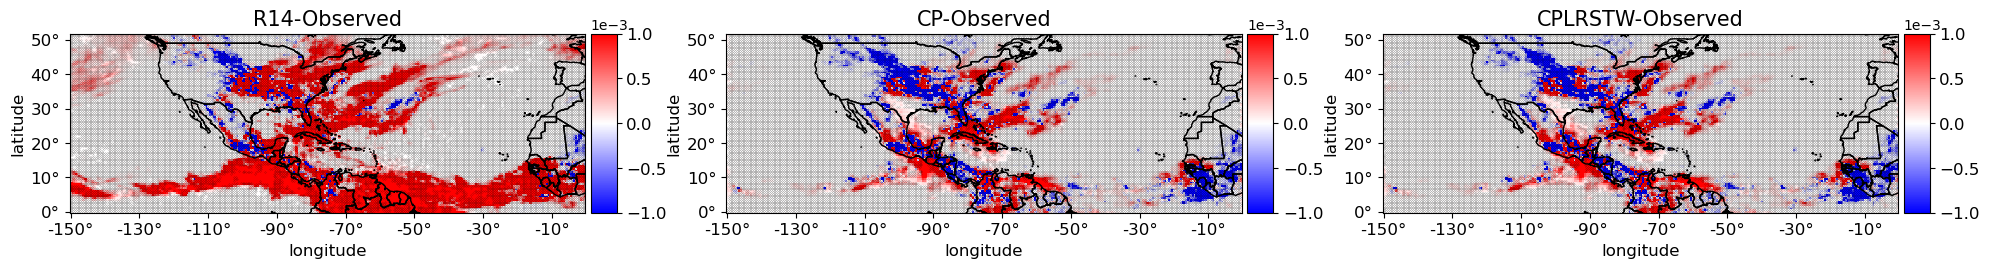

In [53]:
def format_degrees(x, pos):
    return f"{int(x)}°"
    
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# Plot 1: Mean difference (cape_precip vs ds)
base = countries.plot(color=(1, 1, 1, 0.0), edgecolor='black', zorder=2, ax=axs[0])
im0 = ((ds.cape_precip.sel(time=slice('2022-01-01', '2023-12-31')).isel(lat=slice(0, 208), lon=slice(0, 300))/slope) - ds.sel(time=slice('2022-01-01', '2023-12-31')).isel(lat=slice(0, 208), lon=slice(0, 300)).ltg).mean(dim='time').plot(ax=base, cmap='bwr', zorder=1, vmin=-1E-3, vmax=1E-3, add_colorbar=False)

# Extract lat/lon coordinates and significance
lats = ds.isel(lat=slice(0, 208), lon=slice(0, 300)).lat.values
lons = ds.isel(lat=slice(0, 208), lon=slice(0, 300)).lon.values
significance_r14 = ci_results_r14["significance"]  # 2D array with the same shape as lat/lon

# Apply stippling for non-significant locations (significance == 0)
non_sig_r14 = significance_r14 == 0

# Get the indices where the significance is 0 (not significant)
lat_indices_r14, lon_indices_r14 = np.where(non_sig_r14)

# Plot the stippling
axs[0].scatter(lons[lon_indices_r14], lats[lat_indices_r14], color="black", s=0.01, zorder=3)

# Colorbar for plot 1
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im0, cax=cax)
#cbar.set_label('strokes/(km²·yr)', fontsize=10)
cbar.formatter = ScalarFormatter()
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=12)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-3, 3))

# Plot labels and formatting for plot 1
axs[0].set_xticks(range(-150, 1, 20))
axs[0].set_yticks(range(0, 51, 10))
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[0].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[0].set_title('R14-Observed', fontsize=15)
axs[0].set_xlabel('longitude', fontsize=12)
axs[0].set_ylabel('latitude', fontsize=12)

# Plot 2: Mean difference (cp vs ds)
base = countries.plot(color=(1, 1, 1, 0.0), edgecolor='black', zorder=2, ax=axs[1])
im1 = (cp.ltg - ds.sel(time=slice('2022-01-01', '2023-12-31')).isel(lat=slice(0, 208), lon=slice(0, 300)).ltg).mean(dim='time').plot(ax=base, cmap='bwr', zorder=1, vmin=-1E-3, vmax=1E-3, add_colorbar=False)

# Extract lat/lon coordinates and significance
lats = cp.lat.values
lons = cp.lon.values
significance_cp = ci_results_cp["significance"]  # 2D array with the same shape as lat/lon

# Apply stippling for non-significant locations (significance == 0)
non_sig_cp = significance_cp == 0

# Get the indices where the significance is 0 (not significant)
lat_indices_cp, lon_indices_cp = np.where(non_sig_cp)

# Plot the stippling
axs[1].scatter(lons[lon_indices_cp], lats[lat_indices_cp], color="black", s=0.01, zorder=3)

# Colorbar for plot 2
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im1, cax=cax)
#cbar.set_label('strokes/(km²·yr)', fontsize=10)
cbar.formatter = ScalarFormatter()
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=12)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-3, 3))

# Plot labels and formatting for plot 2
axs[1].set_xticks(range(-150, 1, 20))
axs[1].set_yticks(range(0, 51, 10))
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[1].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[1].set_title('CP-Observed', fontsize=15)
axs[1].set_xlabel('longitude', fontsize=12)
axs[1].set_ylabel('latitude', fontsize=12)

# Plot 3: Mean difference (cplrstw vs ds)
base = countries.plot(color=(1, 1, 1, 0.0), edgecolor='black', zorder=2, ax=axs[2])
im2 = (cplrstw.ltg - ds.sel(time=slice('2022-01-01', '2023-12-31')).isel(lat=slice(0, 208), lon=slice(0, 300)).ltg).mean(dim='time').plot(ax=base, cmap='bwr', zorder=1, vmin=-1E-3, vmax=1E-3, add_colorbar=False)

# Extract lat/lon coordinates and significance
lats = cplrstw.lat.values
lons = cplrstw.lon.values
significance_cplrstw = ci_results_cplrstw["significance"]  # 2D array with the same shape as lat/lon

# Apply stippling for non-significant locations (significance == 0)
non_sig_cplrstw = significance_cplrstw == 0

# Get the indices where the significance is 0 (not significant)
lat_indices_cplrstw, lon_indices_cplrstw = np.where(non_sig_cplrstw)

# Plot the stippling
axs[2].scatter(lons[lon_indices_cplrstw], lats[lat_indices_cplrstw], color="black", s=0.01, zorder=3)

# Colorbar for plot 3
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im1, cax=cax)
#cbar.set_label('strokes/(km²·yr)', fontsize=10)
cbar.formatter = ScalarFormatter()
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=12)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-3, 3))

# Plot labels and formatting for plot 3
axs[2].set_xticks(range(-150, 1, 20))
axs[2].set_yticks(range(0, 51, 10))
axs[2].tick_params(axis='both', which='major', labelsize=12)
axs[2].xaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[2].yaxis.set_major_formatter(mticker.FuncFormatter(format_degrees))
axs[2].set_title('CPLRSTW-Observed', fontsize=15)
axs[2].set_xlabel('longitude', fontsize=12)
axs[2].set_ylabel('latitude', fontsize=12)

# Figure 5: Modeled vs. Observed Contour Plots

In [8]:
import xarray as xr
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.stats import linregress
from shapely.geometry import Point
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#Load input and output datasets
ds = xr.open_dataset('data/input_data/input_sample.nc')
cp = xr.open_dataset('data/cnn_output/cp_sample.nc')
cplrstw = xr.open_dataset('data/cnn_output/cplrstw_sample_main.nc')

In [3]:
#Set pixels with greater than or equal to 50% of land to land, pixels with less than 50% land to ocean
mask = np.where(ds.lsm.values >= 0.5, 1, 0)
mask_da = xr.DataArray(mask, dims=["time", "lat", "lon"], coords={"time": ds.time, "lat": ds.lat, "lon": ds.lon})
ds['land_sea_mask'] = mask_da
ds

<xarray.Dataset> Size: 14MB
Dimensions:        (time: 8, lat: 104, lon: 300)
Coordinates:
  * time           (time) datetime64[ns] 64B 2022-06-06 ... 2022-06-09T12:00:00
  * lat            (lat) float64 832B 0.0 0.5 1.0 1.5 ... 50.0 50.5 51.0 51.5
  * lon            (lon) float64 2kB -150.0 -149.5 -149.0 ... -1.5 -1.0 -0.5
Data variables:
    cape           (time, lat, lon) float32 998kB ...
    precipitation  (time, lat, lon) float32 998kB ...
    lsm            (time, lat, lon) float32 998kB 0.0 0.0 0.0 ... 0.9967 0.9909
    rh             (time, lat, lon) float64 2MB ...
    shear          (time, lat, lon) float64 2MB ...
    t2m            (time, lat, lon) float32 998kB ...
    wcd            (time, lat, lon) float32 998kB ...
    cape_precip    (time, lat, lon) float32 998kB ...
    ltg            (time, lat, lon) float64 2MB ...
    land_sea_mask  (time, lat, lon) int64 2MB 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1

In [4]:
#Calculate slope for R14 parameterization
x = ds.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true = ds.cape_precip.mean(dim='time').stack(point=["lat", "lon"])
y_11 = x

slope, intercept, r_value, p_value, std_err = linregress(x, y_true)

## Whole Domain

/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/tmp/ipykernel_2442831/3848955470.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/3848955470.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/3848955470.py:38: UserWarning: Log scale: 

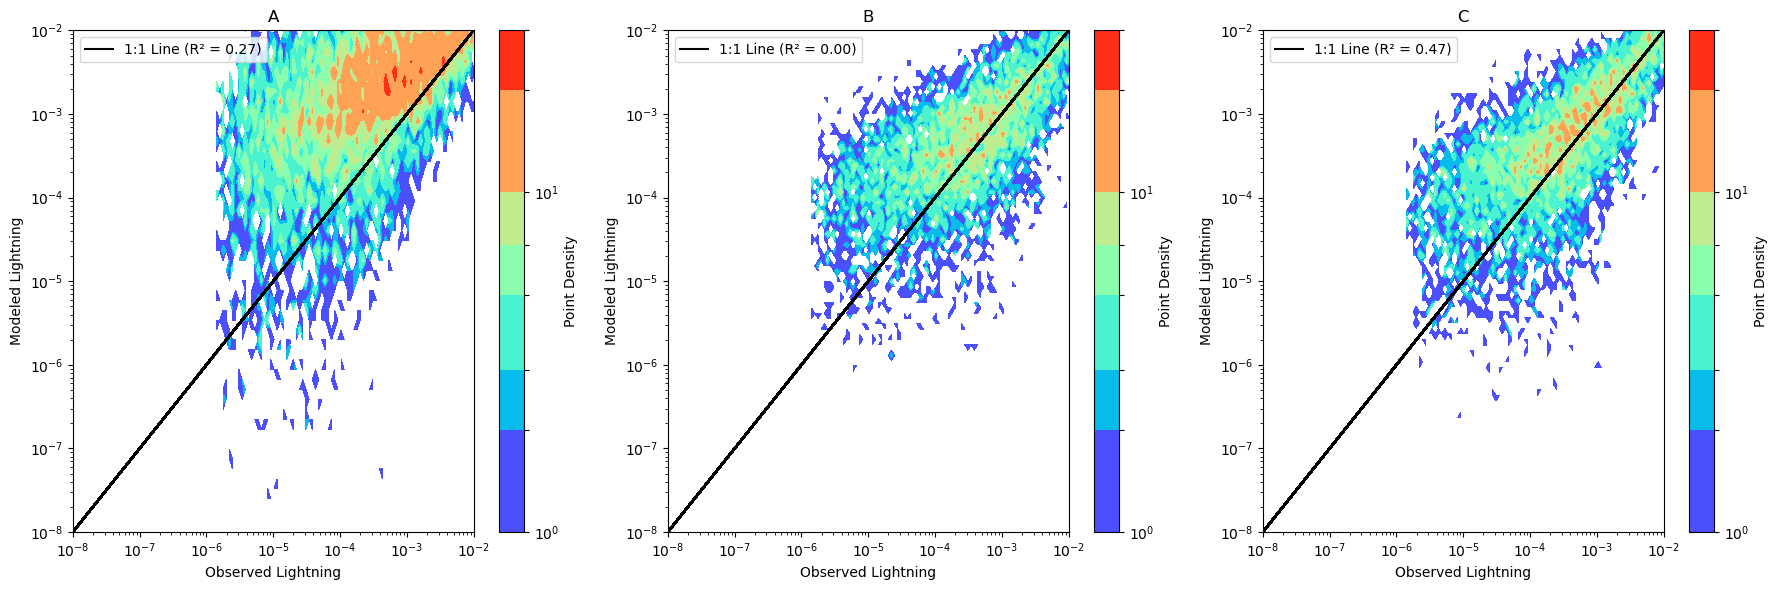

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Prepare your data
x = ds.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true_1 = (ds.cape_precip/slope).mean(dim='time').stack(point=["lat", "lon"])
y_true_2 = cp.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true_3 = cplrstw.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_11 = x

# Regression
slope_1, intercept_1, *_ = linregress(x, y_true_1)
slope_2, intercept_2, *_ = linregress(x, y_true_2)
slope_3, intercept_3, *_ = linregress(x, y_true_3)

# R²
r2_11_1 = r2_score(y_true_1, y_11)
r2_11_2 = r2_score(y_true_2, y_11)
r2_11_3 = r2_score(y_true_3, y_11)

# Common x values for 1:1 line
x_vals = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)

# Function to make contour plot
def plot_contour(ax, x_data, y_data, r2_val, title):
    # Remove non-finite points
    mask = np.isfinite(x_data) & np.isfinite(y_data) & (x_data > 0) & (y_data > 0)
    x_data, y_data = x_data[mask], y_data[mask]

    # Log bins
    x_bins = np.logspace(np.log10(min(x_data)), np.log10(max(x_data)), 100)
    y_bins = np.logspace(np.log10(min(y_data)), np.log10(max(y_data)), 100)

    # 2D histogram
    H, xedges, yedges = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins])

    # Transpose H for plotting
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())

    # Add 1:1 line
    ax.plot(x, x, color='black', linestyle='-', label=f"1:1 Line (R² = {r2_val:.2f})")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1E-8, 1E-2])
    ax.set_ylim([1E-8, 1E-2])
    ax.set_xlabel("Observed Lightning")
    ax.set_ylabel("Modeled Lightning")
    ax.set_title(title)
    ax.legend()
    plt.colorbar(contour, ax=ax, label='Point Density')

# Generate plots
plot_contour(axs[0], x, y_true_1, r2_11_1, "A")
plot_contour(axs[1], x, y_true_2, r2_11_2, "B")
plot_contour(axs[2], x, y_true_3, r2_11_3, "C")

plt.tight_layout()
plt.show()


## Land

/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/tmp/ipykernel_2442831/1029179763.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/1029179763.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/1029179763.py:38: UserWarning: Log scale: 

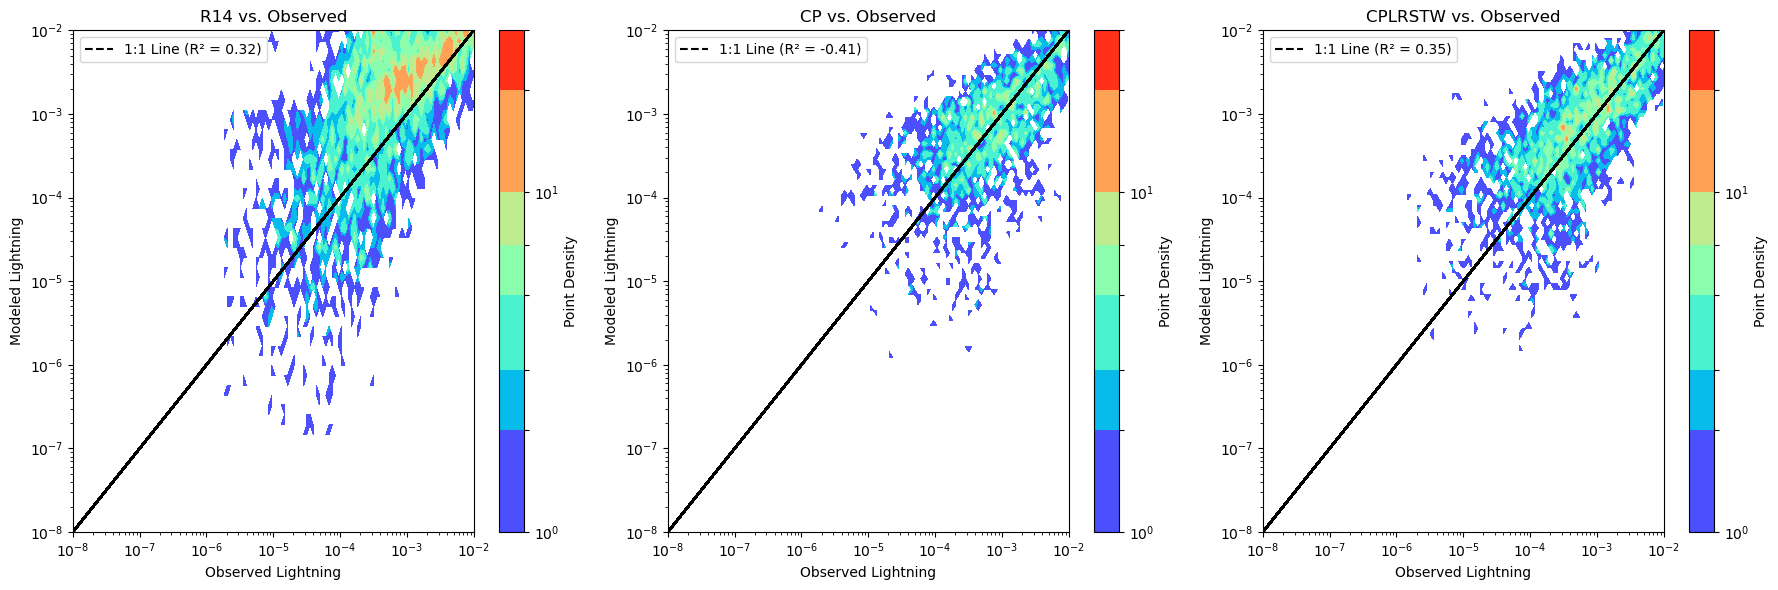

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Prepare your data
x_land = ds.where(ds['land_sea_mask'] == 1).ltg.mean(dim='time').stack(points=("lat", "lon")).dropna(dim="points")
y_true_1_land = (ds.cape_precip/slope).where(ds['land_sea_mask'] == 1).mean(dim='time').stack(points=["lat", "lon"]).dropna(dim="points")
y_true_2_land = cp.where(ds['land_sea_mask'] == 1).ltg.mean(dim='time').stack(points=("lat", "lon")).dropna(dim="points")
y_true_3_land = cplrstw.where(ds['land_sea_mask'] == 1).ltg.mean(dim='time').stack(points=("lat", "lon")).dropna(dim="points")
y_11_land = x_land

# Regression
slope_1_land, intercept_1_land, *_ = linregress(x_land, y_true_1_land)
slope_2_land, intercept_2_land, *_ = linregress(x_land, y_true_2_land)
slope_3_land, intercept_3_land, *_ = linregress(x_land, y_true_3_land)

# R²
r2_11_1_land = r2_score(y_true_1_land, y_11_land)
r2_11_2_land = r2_score(y_true_2_land, y_11_land)
r2_11_3_land = r2_score(y_true_3_land, y_11_land)

# Common x values for 1:1 line
x_vals_land = np.logspace(np.log10(min(x_land)), np.log10(max(x_land)), 100)

# Function to make contour plot
def plot_contour(ax, x_data, y_data, r2_val, title):
    # Remove non-finite points
    mask = np.isfinite(x_data) & np.isfinite(y_data) & (x_data > 0) & (y_data > 0)
    x_data, y_data = x_data[mask], y_data[mask]

    # Log bins
    x_bins = np.logspace(np.log10(min(x_data)), np.log10(max(x_data)), 100)
    y_bins = np.logspace(np.log10(min(y_data)), np.log10(max(y_data)), 100)

    # 2D histogram
    H, xedges, yedges = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins])

    # Transpose H for plotting
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())

    # Add 1:1 line
    ax.plot(x, x, color='black', linestyle='--', label=f"1:1 Line (R² = {r2_val:.2f})")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1E-8, 1E-2])
    ax.set_ylim([1E-8, 1E-2])
    ax.set_xlabel("Observed Lightning")
    ax.set_ylabel("Modeled Lightning")
    ax.set_title(title)
    ax.legend()
    plt.colorbar(contour, ax=ax, label='Point Density')

# Generate plots
plot_contour(axs[0], x_land, y_true_1_land, r2_11_1_land, "R14 vs. Observed")
plot_contour(axs[1], x_land, y_true_2_land, r2_11_2_land, "CP vs. Observed")
plot_contour(axs[2], x_land, y_true_3_land, r2_11_3_land, "CPLRSTW vs. Observed")

plt.tight_layout()
plt.show()


## Ocean

/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/disk/p/rjones98/anaconda3/envs/plotenv/lib/python3.9/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/tmp/ipykernel_2442831/1169338009.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/1169338009.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/1169338009.py:38: UserWarning: Log scale: 

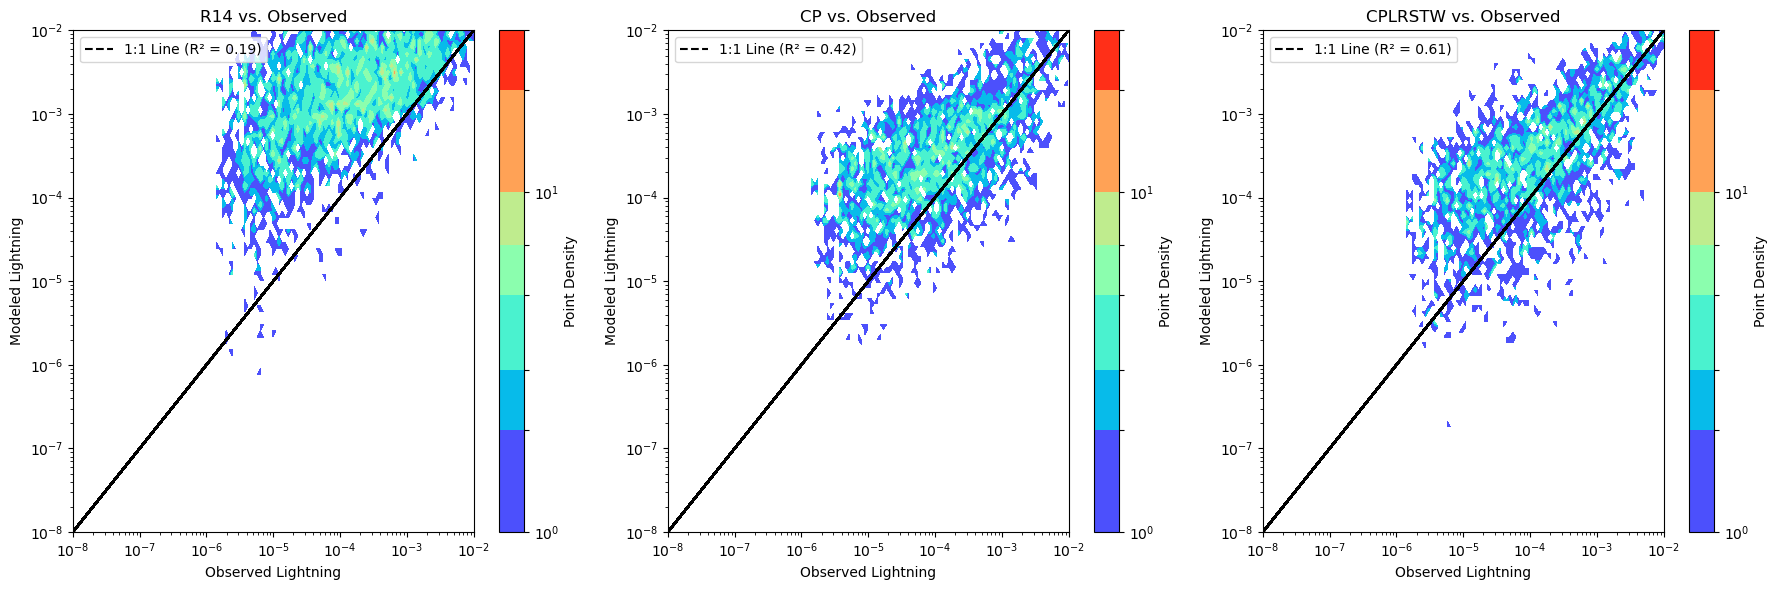

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Prepare your data
x_ocean = ds.where(ds['land_sea_mask'] == 0).ltg.mean(dim='time').stack(points=("lat", "lon")).dropna(dim="points")
y_true_1_ocean = (ds.cape_precip/slope).where(ds['land_sea_mask'] == 0).mean(dim='time').stack(points=["lat", "lon"]).dropna(dim="points")
y_true_2_ocean = cp.where(ds['land_sea_mask'] == 0).ltg.mean(dim='time').stack(points=("lat", "lon")).dropna(dim="points")
y_true_3_ocean = cplrstw.where(ds['land_sea_mask'] == 0).ltg.mean(dim='time').stack(points=("lat", "lon")).dropna(dim="points")
y_11_ocean = x_ocean

# Regression
slope_1_ocean, intercept_1_ocean, *_ = linregress(x_ocean, y_true_1_ocean)
slope_2_ocean, intercept_2_ocean, *_ = linregress(x_ocean, y_true_2_ocean)
slope_3_ocean, intercept_3_ocean, *_ = linregress(x_ocean, y_true_3_ocean)

# R²
r2_11_1_ocean = r2_score(y_true_1_ocean, y_11_ocean)
r2_11_2_ocean = r2_score(y_true_2_ocean, y_11_ocean)
r2_11_3_ocean = r2_score(y_true_3_ocean, y_11_ocean)

# Common x values for 1:1 line
x_vals_ocean = np.logspace(np.log10(min(x_ocean)), np.log10(max(x_ocean)), 100)

# Function to make contour plot
def plot_contour(ax, x_data, y_data, r2_val, title):
    # Remove non-finite points
    mask = np.isfinite(x_data) & np.isfinite(y_data) & (x_data > 0) & (y_data > 0)
    x_data, y_data = x_data[mask], y_data[mask]

    # Log bins
    x_bins = np.logspace(np.log10(min(x_data)), np.log10(max(x_data)), 100)
    y_bins = np.logspace(np.log10(min(y_data)), np.log10(max(y_data)), 100)

    # 2D histogram
    H, xedges, yedges = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins])

    # Transpose H for plotting
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())

    # Add 1:1 line
    ax.plot(x, x, color='black', linestyle='--', label=f"1:1 Line (R² = {r2_val:.2f})")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1E-8, 1E-2])
    ax.set_ylim([1E-8, 1E-2])
    ax.set_xlabel("Observed Lightning")
    ax.set_ylabel("Modeled Lightning")
    ax.set_title(title)
    ax.legend()
    plt.colorbar(contour, ax=ax, label='Point Density')

# Generate plots
plot_contour(axs[0], x_ocean, y_true_1_ocean, r2_11_1_ocean, "R14 vs. Observed")
plot_contour(axs[1], x_ocean, y_true_2_ocean, r2_11_2_ocean, "CP vs. Observed")
plot_contour(axs[2], x_ocean, y_true_3_ocean, r2_11_3_ocean, "CPLRSTW vs. Observed")

plt.tight_layout()
plt.show()


## Combined

/tmp/ipykernel_2442831/296036461.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/296036461.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/296036461.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/296036461.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())
/tmp/ipykernel_2442831/296036461.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNor

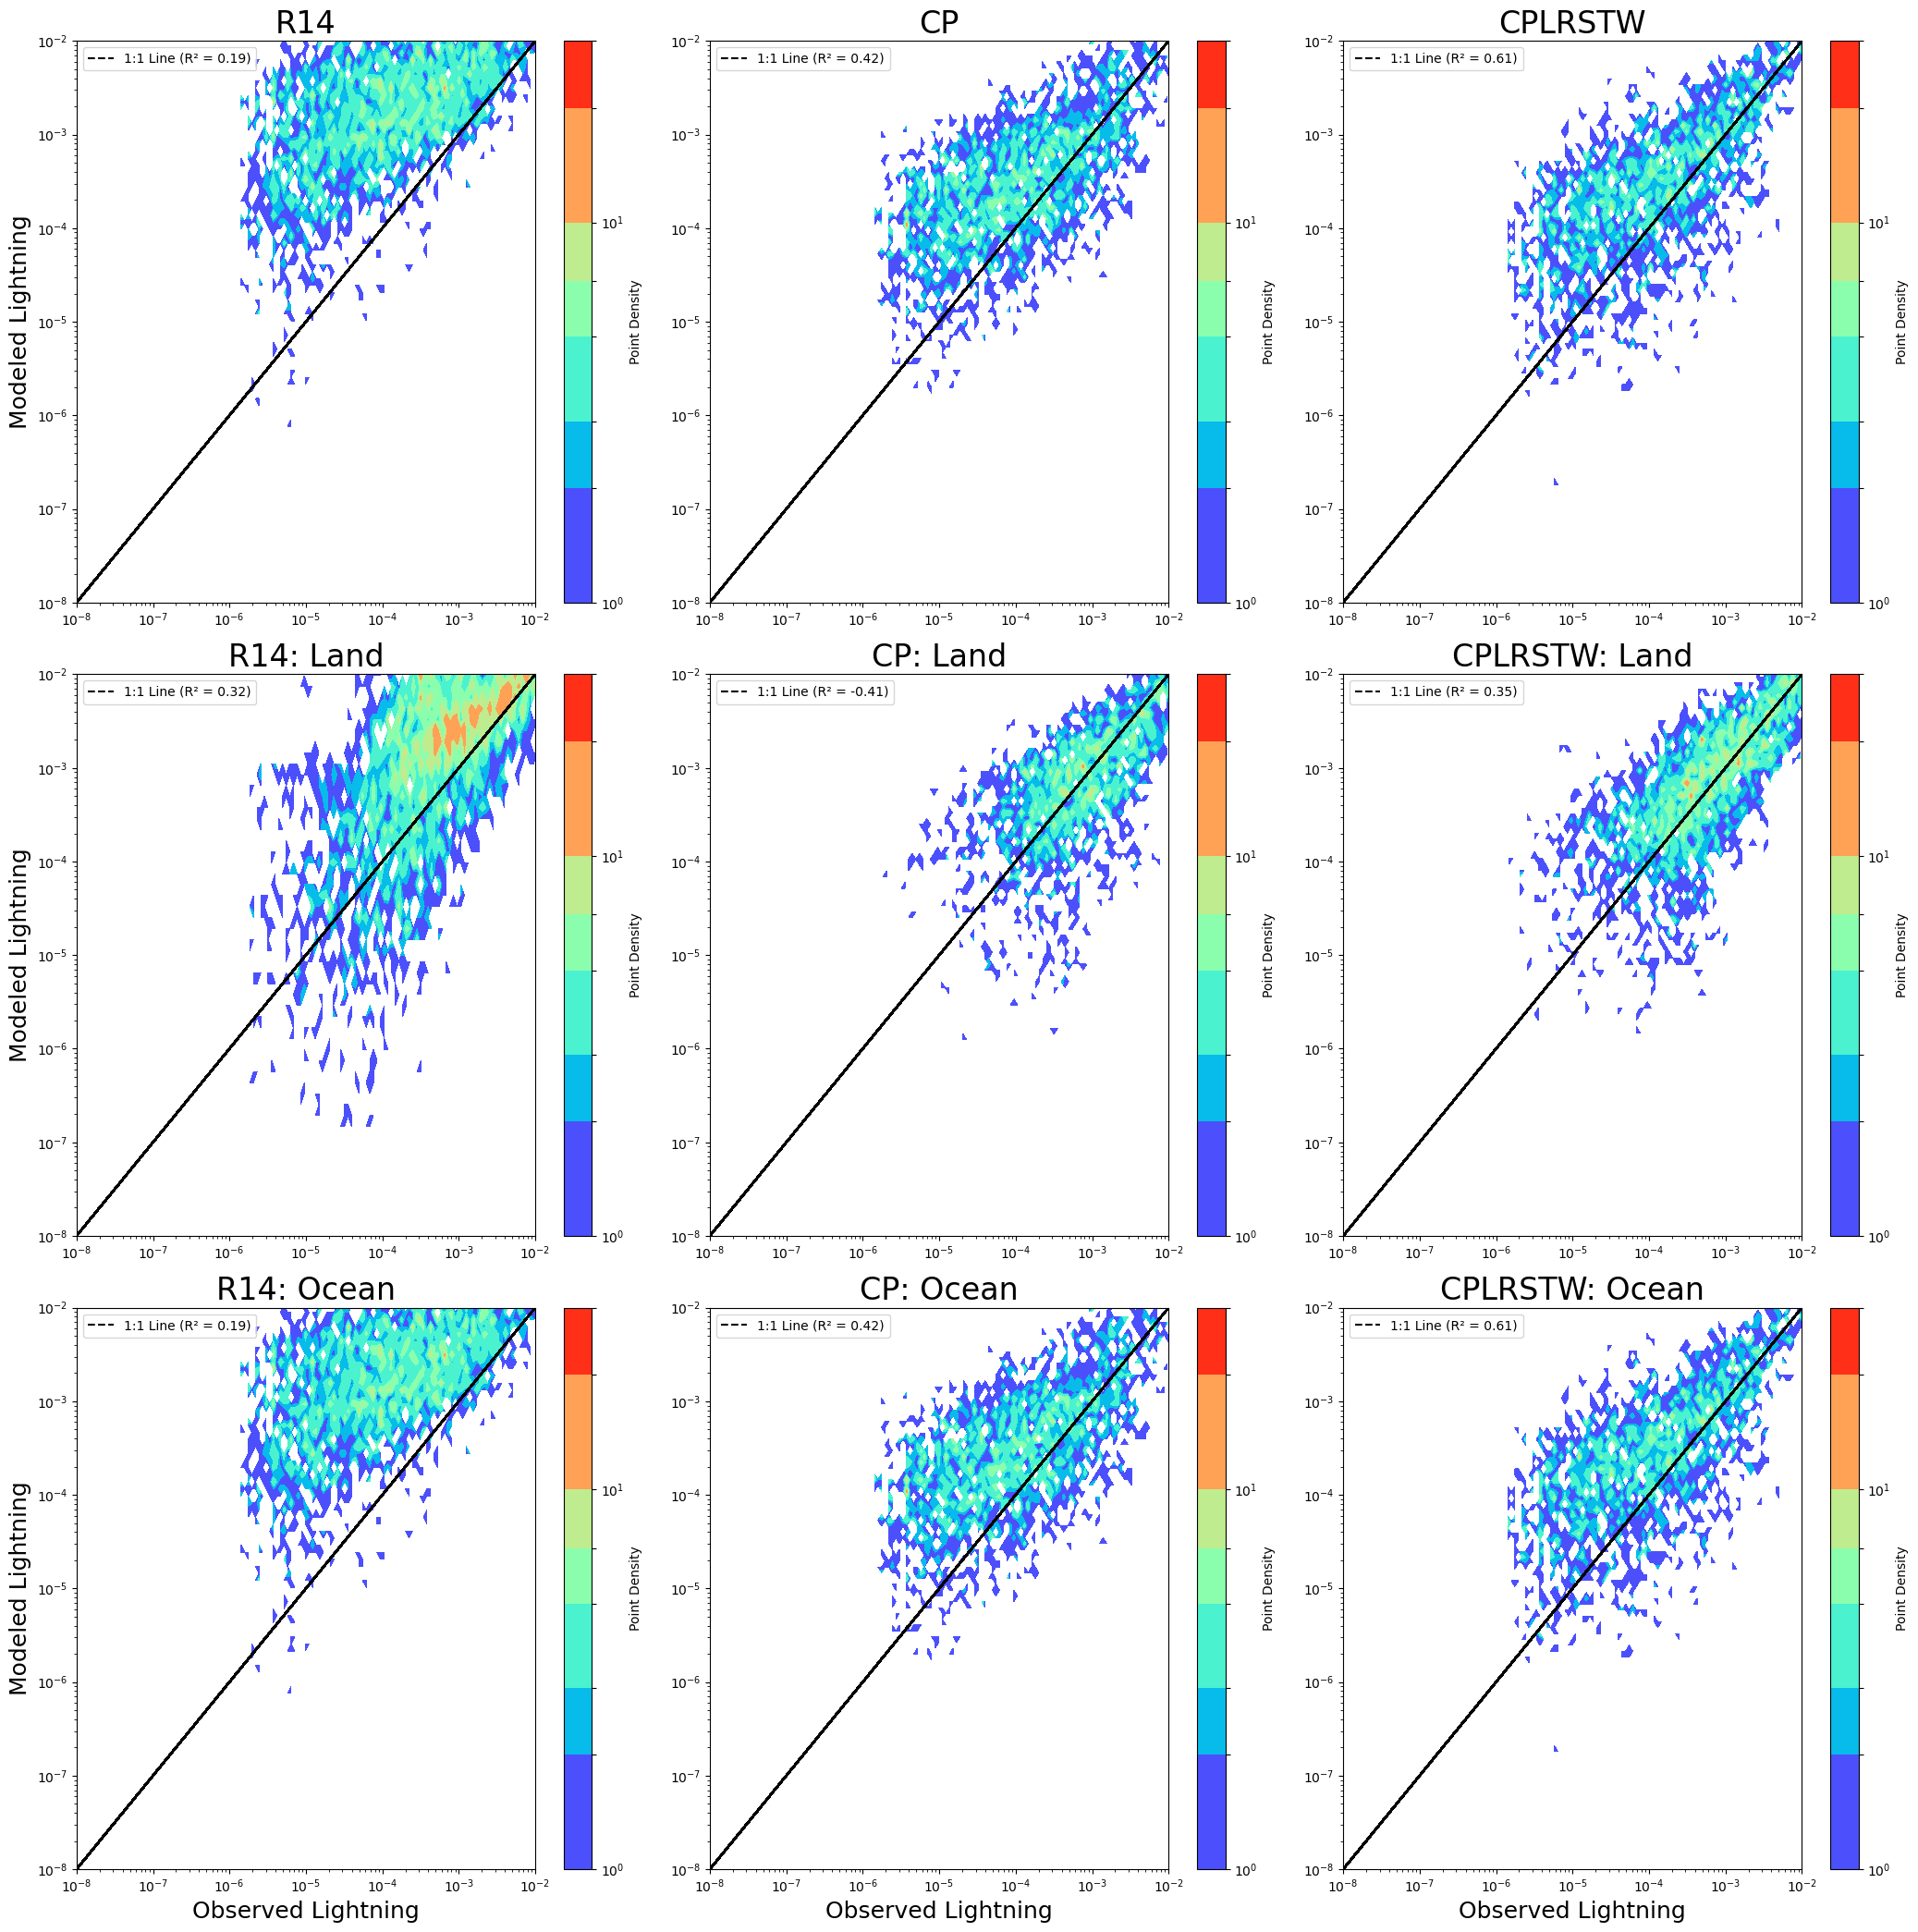

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(21, 21))

def plot_contour(ax, x_data, y_data, r2_val, title):
    # Remove non-finite points
    mask = np.isfinite(x_data) & np.isfinite(y_data) & (x_data > 0) & (y_data > 0)
    x_data, y_data = x_data[mask], y_data[mask]

    # Log bins
    x_bins = np.logspace(np.log10(min(x_data)), np.log10(max(x_data)), 100)
    y_bins = np.logspace(np.log10(min(y_data)), np.log10(max(y_data)), 100)

    # 2D histogram
    H, xedges, yedges = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins])

    # Transpose H for plotting
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    contour = ax.contourf(X, Y, H.T, levels=[1, 2, 3, 5, 7, 10, 20, 30], cmap='rainbow', norm=LogNorm())

    # Add 1:1 line
    ax.plot(x, x, color='black', linestyle='--', label=f"1:1 Line (R² = {r2_val:.2f})")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1E-8, 1E-2])
    ax.set_ylim([1E-8, 1E-2])
    ax.set_title(title, fontsize=24)
    ax.legend()
    plt.colorbar(contour, ax=ax, label='Point Density')

plot_contour(axs[0, 0], x, y_true_1, r2_11_1, "R14")
plot_contour(axs[0, 1], x, y_true_2, r2_11_2, "CP")
plot_contour(axs[0, 2], x, y_true_3, r2_11_3, "CPLRSTW")

plot_contour(axs[1, 0], x_land, y_true_1_land, r2_11_1_land, "R14: Land")
plot_contour(axs[1, 1], x_land, y_true_2_land, r2_11_2_land, "CP: Land")
plot_contour(axs[1, 2], x_land, y_true_3_land, r2_11_3_land, "CPLRSTW: Land")

plot_contour(axs[2, 0], x_ocean, y_true_1_ocean, r2_11_1_ocean, "R14: Ocean")
plot_contour(axs[2, 1], x_ocean, y_true_2_ocean, r2_11_2_ocean, "CP: Ocean")
plot_contour(axs[2, 2], x_ocean, y_true_3_ocean, r2_11_3_ocean, "CPLRSTW: Ocean")

axs[0, 0].set_ylabel("Modeled Lightning", fontsize=18)
axs[1, 0].set_ylabel("Modeled Lightning", fontsize=18)
axs[2, 0].set_ylabel("Modeled Lightning", fontsize=18)
axs[2, 0].set_xlabel("Observed Lightning", fontsize=18)
axs[2, 1].set_xlabel("Observed Lightning", fontsize=18)
axs[2, 2].set_xlabel("Observed Lightning", fontsize=18)

plt.tight_layout()
plt.show()

# Figure 6: Domain-Wide FSS Time Series and MFSS

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.stats import linregress
from shapely.geometry import Point
import seaborn as sns
from scipy.ndimage import uniform_filter

In [2]:
#Load input and output datasets
ds = xr.open_dataset('data/input_data/input_sample.nc')
cp = xr.open_dataset('data/cnn_output/cp_sample.nc')
cplrstw = xr.open_dataset('data/cnn_output/cplrstw_sample_main.nc')

In [3]:
#Calculate slope for R14 parameterization
x = ds.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true = ds.cape_precip.mean(dim='time').stack(point=["lat", "lon"])
y_11 = x

slope, intercept, r_value, p_value, std_err = linregress(x, y_true)

## FSS

In [4]:
def compute_fss(obs, pred, threshold, window_size):
    """
    Compute the Fractions Skill Score (FSS) for a given observation and prediction field.

    Parameters:
    - obs (np.array): 2D binary observation field (1 for event, 0 for no event)
    - pred (np.array): 2D binary prediction field (1 for event, 0 for no event)
    - threshold (float): Threshold to binarize the fields
    - window_size (int): Size of the neighborhood window

    Returns:
    - fss (float): Fractions Skill Score
    """
    # Convert fields to binary based on threshold
    obs_bin = (obs >= threshold).astype(int)
    pred_bin = (pred >= threshold).astype(int)

    # Compute fractional coverage using a moving window
    obs_frac = uniform_filter(obs_bin.astype(float), size=window_size, mode='constant', cval=0)
    pred_frac = uniform_filter(pred_bin.astype(float), size=window_size, mode='constant', cval=0)

    # Compute numerator and denominator of FSS formula
    numerator = np.sum((pred_frac - obs_frac) ** 2)
    denominator = np.sum(pred_frac**2 + obs_frac**2)

    # Compute FSS
    fss = 1 - (numerator / denominator)
    return fss

# Define parameters
threshold = 1E-5  # Define a lightning threshold for event occurrence
window_size = 3  # Example window size (5x5 grid points)

# Extract time range
time_range = ds.time

# Store FSS results for each time step
fss_scores_r14 = []
fss_scores_cp = []
fss_scores_cplrstw = []

for i in range(len(time_range)):
    obs_values = ds.sel(time=time_range[i]).ltg.values
    pred_values_r14 = (ds.sel(time=time_range[i]).cape_precip/slope).values
    pred_values_cp = cp.sel(time=time_range[i]).ltg.values
    pred_values_cplrstw = cplrstw.sel(time=time_range[i]).ltg.values
    
    # Compute FSS
    fss_r14 = compute_fss(obs_values, pred_values_r14, threshold, window_size)
    fss_cp = compute_fss(obs_values, pred_values_cp, threshold, window_size)
    fss_cplrstw = compute_fss(obs_values, pred_values_cplrstw, threshold, window_size)
    
    fss_scores_r14.append(fss_r14)
    fss_scores_cp.append(fss_cp)
    fss_scores_cplrstw.append(fss_cplrstw)

# Convert to xarray DataArray for easy analysis
fss_da_r14 = xr.DataArray(fss_scores_r14, coords={"time": time_range}, dims="time")
fss_da_cp = xr.DataArray(fss_scores_cp, coords={"time": time_range}, dims="time")
fss_da_cplrstw = xr.DataArray(fss_scores_cplrstw, coords={"time": time_range}, dims="time")

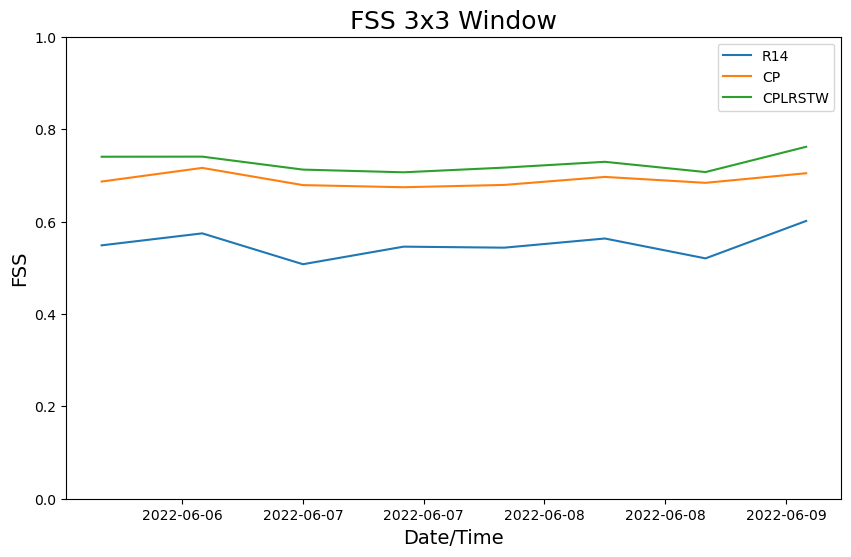

In [5]:
myFmt = DateFormatter("%m-%d-%Y")
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(fss_da_r14.time, fss_da_r14.values, label='R14')
ax.plot(fss_da_cp.time, fss_da_cp.values, label='CP')
ax.plot(fss_da_cplrstw.time, fss_da_cplrstw.values, label='CPLRSTW')
ax.set_title('FSS 3x3 Window', fontsize = 18)
ax.set_xlabel('Date/Time', fontsize = 14)
ax.set_ylabel('FSS', fontsize = 14)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
#ax.xaxis.set_major_formatter(myFmt)

## MFSS

In [6]:
params = {
#    'bins': [0, 1E-8, 1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 1E-2, np.inf], #change for the values you want
    'bins': [0, 1E-8, 1E-7, 1E-6, 1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1E0, np.inf], #change for the values you want
#    'bin_labels': ['0-1E-8','1E-8-1E-7','1E-7-1E-6','1E-6-1E-5','1E-5-1E-4','1E-4-1E-3','1E-3, 1E-2','>1E-2'], #change for the values you want
    'bin_labels': ['0-1E-8','1E-8-1E-7','1E-7-1E-6','1E-6-1E-5','1E-5-1E-4','1E-4-1E-3','1E-3-1E-2','1E-2-1E-1','1E-1-1E0','1E0<'], #change for the values you want
    'n': 3 #neighborhood size nxn
}

# Define parameters
threshold = 1E-5  # Define a lightning threshold for event occurrence
window_size = 3  # Example window size (5x5 grid points)

def compute_fss(obs, pred, lower_bound, upper_bound, window_size):
    # Convert fields to binary based on threshold
    obs_bin = ((obs >= lower_bound) & (obs < upper_bound)).astype(int)
    pred_bin = ((pred >= lower_bound) & (pred < upper_bound)).astype(int)

    # Compute fractional coverage using a moving window
    obs_frac = uniform_filter(obs_bin.astype(float), size=window_size, mode='constant', cval=0)
    pred_frac = uniform_filter(pred_bin.astype(float), size=window_size, mode='constant', cval=0)

    # Compute numerator and denominator of FSS formula
    numerator = np.sum((pred_frac - obs_frac) ** 2)
    denominator = np.sum(pred_frac**2 + obs_frac**2)

    if denominator == 0:
        return np.nan
    return 1 - (numerator / denominator)

fss_bin_r14 = []
fss_bin_cp = []
fss_bin_cplrstw = []

for i in range(len(params['bins']) - 1):
    lower = params['bins'][i]
    upper = params['bins'][i+1]
    fss_cp = compute_fss(ds.ltg.values, cp.ltg.values, lower, upper, params['n'])
    fss_bin_cp.append(fss_cp)

for j in range(len(params['bins']) - 1):
    lower = params['bins'][j]
    upper = params['bins'][j+1]
    fss_cplrstw = compute_fss(ds.ltg.values, cplrstw.ltg.values, lower, upper, params['n'])
    fss_bin_cplrstw.append(fss_cplrstw)

for k in range(len(params['bins']) - 1):
    lower = params['bins'][k]
    upper = params['bins'][k+1]
    fss_r14 = compute_fss(ds.ltg.values, (ds.cape_precip/slope).values, lower, upper, params['n'])
    fss_bin_r14.append(fss_r14)
    
fss_bin_r14 = pd.Series(fss_bin_r14, index=params['bin_labels'])
fss_bin_cp = pd.Series(fss_bin_cp, index=params['bin_labels'])
fss_bin_cplrstw = pd.Series(fss_bin_cplrstw, index=params['bin_labels'])

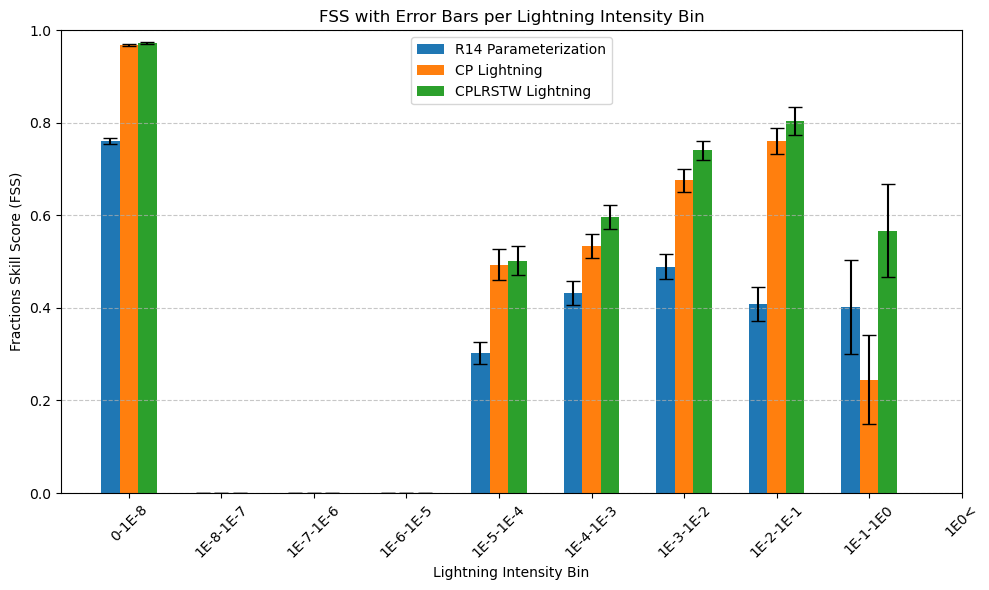

In [7]:
def bootstrap_fss(obs, pred, lower_bound, upper_bound, window_size, n_iterations=1000):
    fss_scores = []
    obs = ((obs >= lower_bound) & (obs < upper_bound)).astype(int)
    pred = ((pred >= lower_bound) & (pred < upper_bound)).astype(int)

    # Flatten time dimension if needed
    if obs.ndim == 3:
        obs = obs.reshape(-1, obs.shape[1], obs.shape[2])
        pred = pred.reshape(-1, pred.shape[1], pred.shape[2])

    n_samples = obs.shape[0]

    for _ in range(n_iterations):
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        obs_sample = np.mean(obs[idx], axis=0)
        pred_sample = np.mean(pred[idx], axis=0)

        obs_frac = uniform_filter(obs_sample.astype(float), size=window_size, mode='constant', cval=0)
        pred_frac = uniform_filter(pred_sample.astype(float), size=window_size, mode='constant', cval=0)

        numerator = np.sum((pred_frac - obs_frac) ** 2)
        denominator = np.sum(pred_frac**2 + obs_frac**2)
        fss = 1 - (numerator / denominator) if denominator > 0 else np.nan
        fss_scores.append(fss)

    return np.mean(fss_scores), np.std(fss_scores)

fss_r14, fss_r14_err = [], []
fss_cp, fss_cp_err = [], []
fss_cplrstw, fss_cplrstw_err = [], []

for i in range(len(params['bins']) - 1):
    lower, upper = params['bins'][i], params['bins'][i+1]
    fss_r, err_r = bootstrap_fss(ds.ltg.values, (ds.cape_precip/slope).values, lower, upper, params['n'])
    fss_c, err_c = bootstrap_fss(ds.ltg.values, cp.ltg.values, lower, upper, params['n'])
    fss_p, err_p = bootstrap_fss(ds.ltg.values, cplrstw.ltg.values, lower, upper, params['n'])

    fss_r14.append(fss_r)
    fss_r14_err.append(err_r)
    fss_cp.append(fss_c)
    fss_cp_err.append(err_c)
    fss_cplrstw.append(fss_p)
    fss_cplrstw_err.append(err_p)
    
fss_series_r14 = pd.Series(fss_r14, index=params['bin_labels'])
fss_series_cp = pd.Series(fss_cp, index=params['bin_labels'])
fss_series_cplrstw = pd.Series(fss_cplrstw, index=params['bin_labels'])

import matplotlib.pyplot as plt

# Grouped bar chart with error bars
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(params['bin_labels']))
bar_width = 0.2

ax.bar(x - bar_width, fss_series_r14.values, bar_width, yerr=fss_r14_err, capsize=5, label='R14 Parameterization')
ax.bar(x, fss_series_cp.values, bar_width, yerr=fss_cp_err, capsize=5, label='CP Lightning')
ax.bar(x + bar_width, fss_series_cplrstw.values, bar_width, yerr=fss_cplrstw_err, capsize=5, label='CPLRSTW Lightning')

ax.set_xticks(x)
ax.set_xticklabels(params['bin_labels'], rotation=45)
ax.set_ylabel('Fractions Skill Score (FSS)')
ax.set_xlabel('Lightning Intensity Bin')
ax.set_title('FSS with Error Bars per Lightning Intensity Bin')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Combined

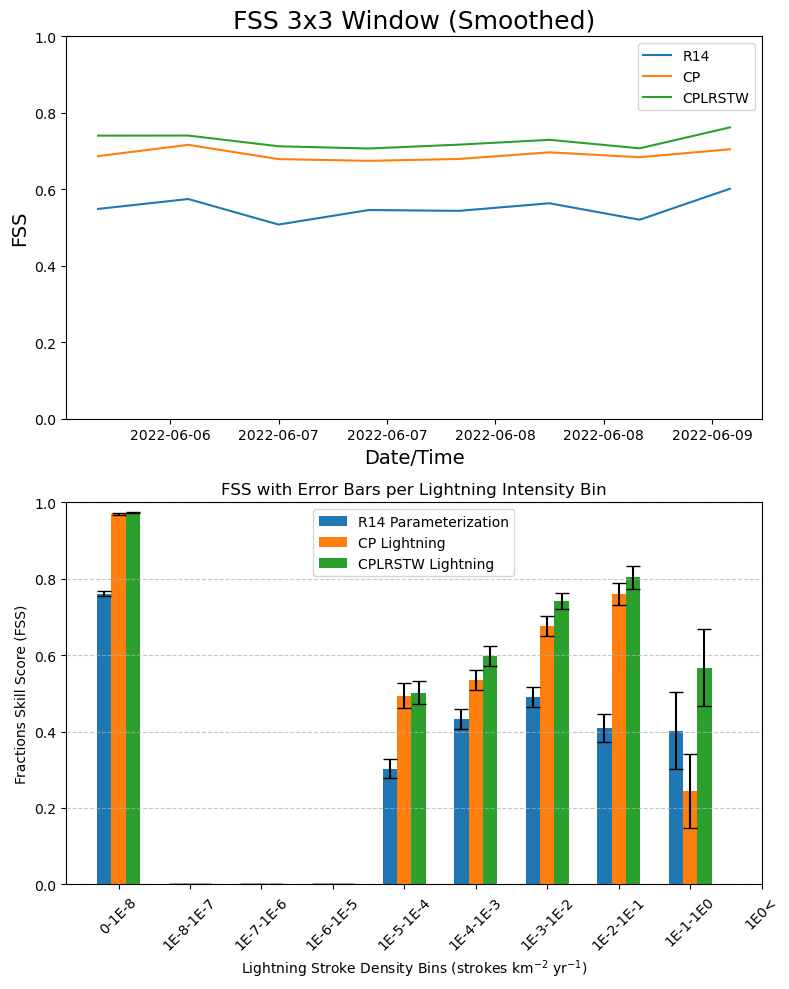

In [10]:
fig, axs = plt.subplots(2, 1, figsize = (8, 10))

# Plot 1
axs[0].plot(fss_da_r14.time, fss_da_r14, label='R14')
axs[0].plot(fss_da_cp.time, fss_da_cp, label='CP')
axs[0].plot(fss_da_cplrstw.time, fss_da_cplrstw, label='CPLRSTW')
axs[0].set_title('FSS 3x3 Window (Smoothed)', fontsize=18)
axs[0].set_xlabel('Date/Time', fontsize=14)
axs[0].set_ylabel('FSS', fontsize=14)
axs[0].legend()
axs[0].set_ylim([0, 1])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))

# Plot 2
x = np.arange(len(params['bin_labels']))
bar_width = 0.2

axs[1].bar(x - bar_width, fss_series_r14.values, bar_width, yerr=fss_r14_err, capsize=5, label='R14 Parameterization')
axs[1].bar(x, fss_series_cp.values, bar_width, yerr=fss_cp_err, capsize=5, label='CP Lightning')
axs[1].bar(x + bar_width, fss_series_cplrstw.values, bar_width, yerr=fss_cplrstw_err, capsize=5, label='CPLRSTW Lightning')

axs[1].set_xticks(x)
axs[1].set_xticklabels(params['bin_labels'], rotation=45)
axs[1].set_ylabel('Fractions Skill Score (FSS)')
axs[1].set_xlabel('Lightning Stroke Density Bins (strokes km$^{-2}$ yr$^{-1}$)')
axs[1].set_title('FSS with Error Bars per Lightning Intensity Bin')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Figure 7: Northern Hemisphere Maps

In [6]:
import xarray as xr
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.stats import linregress
from shapely.geometry import Point
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
PATH_TO_SHAPEFILE = '/home/giantstep2/rjones98/data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

ERROR 1: PROJ: proj_create_from_database: Open of /home/disk/p/rjones98/anaconda3/envs/plotenv/share/proj failed


In [3]:
#Load input and output datasets
ds = xr.open_dataset('data/input_data/input_sample.nc')
cp = xr.open_dataset('data/cnn_output/cp_sample.nc')
cplrstw = xr.open_dataset('data/cnn_output/cplrstw_sample_main.nc')

In [4]:
#Calculate slope for R14 parameterization
x = ds.ltg.mean(dim='time').stack(point=["lat", "lon"])
y_true = ds.cape_precip.mean(dim='time').stack(point=["lat", "lon"])
y_11 = x

slope, intercept, r_value, p_value, std_err = linregress(x, y_true)

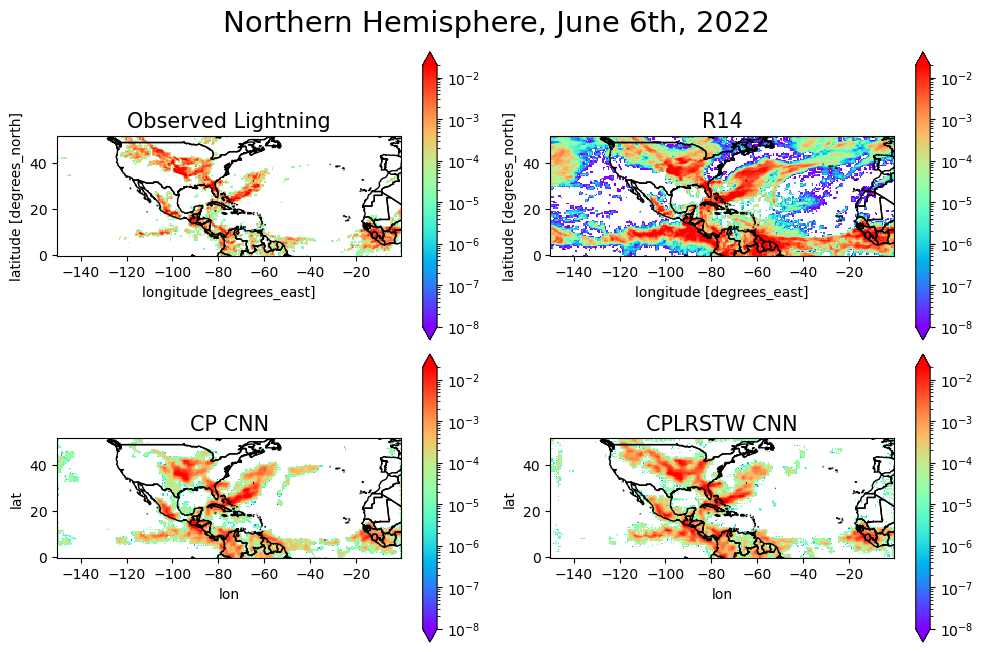

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6.6))
    
base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[0, 0])
ds.sel(time='2022-06-06').ltg.mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),cbar_kwargs={"label": ""})
axs[0, 0].set_title('Observed Lightning', fontsize = 15)

base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[0, 1])
(ds.cape_precip/slope).sel(time='2022-06-06').mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),cbar_kwargs={"label": ""})
axs[0, 1].set_title('R14', fontsize = 15)

base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[1, 0])
cp.sel(time='2022-06-06').ltg.mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),cbar_kwargs={"label": ""})
axs[1, 0].set_title('CP CNN', fontsize = 15)

base = countries.plot(color=(1,1,1,0.0), edgecolor='black',zorder=2, ax=axs[1, 1])
cplrstw.sel(time='2022-06-06').ltg.mean(dim='time').plot(ax=base,cmap='rainbow',zorder=1,norm=colors.LogNorm(vmin=1E-8, vmax=2E-2),cbar_kwargs={"label": ""})
axs[1, 1].set_title('CPLRSTW CNN', fontsize = 15)

plt.suptitle(f"Northern Hemisphere, June 6th, 2022", fontsize = 21)
plt.tight_layout(pad=1.0)

# Figure 8: Northern Hemisphere FSS and MFSS

Due to the spatial and temporal limits of the sample data, the code for Figure 8 would be the same as the code from Figure 6. Modifications to this code for use with larger datasets would be used to limit the spatial and temporal focuses of the data, through the use of .sel commands.

# Figures 9 and 10

The sample data does not contain data south of the equator. As such, Figures 9 and 10 are not remade here. However, the code for figures 9 and 10 is the same as the code for Figures 7 and 8, just with changes to the temporal, latitudinal and longitudinal constraints.